In [432]:
%matplotlib inline

import os
import pickle
import dill
import matplotlib as mpl
from matplotlib import pyplot as plt
import quandl
import pandas as pd
import numpy as np
import functools
import datetime as dt
from pandas.tseries.offsets import MonthEnd
import statsmodels.api as sm
from sklearn.linear_model import Lasso
import time
from scipy.stats import norm
import scipy.stats as stats

from tqdm import tqdm
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.robust.norms import HuberT, TukeyBiweight

import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from seaborn import pairplot

In [433]:
import warnings
warnings.filterwarnings('ignore')

In [434]:
mpl.rcParams["figure.figsize"] = (8, 6)

#### Import the data from Quandl

In [202]:
quandl.ApiConfig.api_key = "ksPPvPR9UxF5mZNeFgNT" 
@functools.lru_cache(maxsize=1600)
def fetch_quandl(securities, start, end, returns="pandas"):
    qdata = quandl.get(list(securities), returns=returns, trim_start=start, trim_end = end)
    return qdata

#### Clean the data from Quandl

In [203]:
def clean_quandl_columns(dataframe):
    replacement_columns = {}
    for c in dataframe.columns:
        series_name, variable = c.split(' - ')
        source_name, asset = series_name.split('/')
        replacement_columns[c] = asset +":"+variable
    renamed_data = dataframe.rename(columns=replacement_columns)
    return renamed_data

#### Gathered top 40 stocks for each ETF, If the ETF has less than 40 stocks, all the stocks are taken

In [204]:
etfs_list = ['SPY','QQQ','XLU', 'VOX', 'SMH', 'XBI', 'XLF', 'XOP', 'OIH', 'XRT', 'XLV']

In [205]:
XLU_stocks = ['NEE', 'DUK', 'D', 'SO', 'EXC', 'AEP', 'SRE', 'PEG', 'XEL', 'ED', 'WEC', 'ES', 'DTE', 'PPL', 'FE', 'AWK', 'EIX', 'ETR', 'AEE', 'CMS', 'EVRG', 'CNP', 'ATO', 'LNT', 'AES', 'PNW', 'NI', 'NRG']
VOX_stocks = ['FB', 'GOOG', 'GOOGL', 'VZ', 'CMCSA', 'DIS', 'T', 'NFLX', 'CHTR', 'TMUS', 'ATVI', 'EA', 'TWTR', 'LBTYK', 'LBRDA', 'ZAYO', 'DISCK', 'OMC', 'IAC', 'S', 'Z', 'CBS', 'TTWO', 'FOXA', 'CTL', 'FWONK', 'VIAB', 'LYV', 'IPG', 'SIRI', 'DISH', 'SNAP', 'ZNGA', 'LSXMK', 'SBGI', 'CABO', 'GLIBA', 'TDS', 'FOX', 'MSG']
SMH_stocks = ['INTC', 'TSM', 'QCOM', 'TXN', 'ASML', 'NVDA', 'AVGO', 'AMAT', 'LRCX', 'NXPI', 'AMD', 'ADI', 'MU', 'XLNX', 'CDNS', 'MCHP', 'KLAC', 'MRVL', 'MXIM', 'SWKS', 'STM', 'ON', 'OLED', 'TER', 'QRVO']
XBI_stocks = ['ARRY', 'GBT', 'SAGE', 'EXAS', 'CELG', 'MRTX', 'LGND', 'GILD', 'NBIX', 'ABBV', 'ACAD', 'SGEN', 'INCY', 'ARWR', 'BMRN', 'ALXN', 'VRTX', 'PTLA', 'AMGN', 'SRPT', 'IONS', 'IMMU', 'BLUE', 'EXEL', 'PTCT', 'FOLD', 'ICPT', 'ALNY', 'UTHR', 'REGN', 'ARNA', 'VKTX', 'RARE', 'BIIB', 'RGEN', 'ESPR', 'MYGN', 'BHVN', 'AGIO', 'ANAB']
XLF_stocks = ['JPM', 'BAC', 'WFC', 'C', 'AXP', 'USB', 'CB', 'CME', 'GS', 'PNC', 'MS', 'SPGI', 'BLK', 'SCHW', 'MMC', 'PGR', 'ICE', 'AIG', 'MET', 'AON', 'COF', 'PRU', 'BK', 'AFL', 'TRV', 'BBT', 'ALL', 'MCO', 'STI', 'DFS', 'TROW', 'WLTW', 'SYF', 'MTB', 'STT', 'FITB', 'NTRS', 'AMP', 'HIG']
XOP_stocks = ['APC', 'PXD', 'FANG', 'HES', 'PE', 'EQT', 'COG', 'DK', 'QEP', 'NBL', 'DVN', 'CXO', 'EOG', 'WPX', 'CPE', 'OAS', 'PBF', 'CVX', 'MTDR', 'CLR', 'VLO', 'CRZO', 'XOM', 'XEC', 'CDEV', 'COP', 'AR', 'SWN', 'MRO', 'MUR', 'PSX', 'MPC', 'APA', 'WLL', 'OXY', 'SM', 'HFC', 'CRC', 'PDCE', 'RRC']
OIH_stocks = ['SLB', 'HAL', 'FTI', 'HP', 'TS', 'NOV', 'PTEN', 'BHGE', 'APY', 'RIG', 'CLB', 'ESV', 'MDR', 'OII', 'NBR', 'DRQ', 'RES', 'DO', 'CJ', 'OIS', 'NE', 'SLCA', 'SPN', 'WFTIF']
XRT_stocks = ['CVNA','LAD', 'KMX', 'OLLI', 'RCII', 'ABG', 'AMZN', 'AN', 'PLCE', 'BURL', 'ULTA', 'TSCO', 'FIVE', 'SFLY', 'GPI', 'COST', 'ROST', 'MUSA', 'PAG', 'AZO', 'TIF', 'BKNG', 'GRPN', 'BJ', 'AAP', 'WMT', 'TJX', 'EBAY', 'MNRO', 'CASY', 'BBY', 'CONN', 'GCO', 'ANF', 'DG', 'KR', 'AEO', 'BOOT', 'DLTR', 'SCVL']
XLV_stocks = ['BIIB', 'AGN', 'VRTX', 'EW', 'BAX', 'HUM', 'HCA', 'ALXN', 'REGN', 'ZBH', 'MCK', 'ALGN', 'CNC', 'CERN','A', 'IDXX', 'IQV']

#### Combined all the stocks in a list removing any duplicate ones

In [206]:
stocks_list = list(set(XLU_stocks + VOX_stocks + SMH_stocks + XBI_stocks + XLF_stocks + 
                       XOP_stocks + OIH_stocks + XRT_stocks + XLV_stocks))
print("Number of stocks: ", len(stocks_list))

Number of stocks:  289


#### Analysis period is 46 days from 2019-01-01 to 2019-03-31, Identify first 46 days from the interval

In [207]:
start = '2019-01-01'
end = '2019-03-31'

trading_days = pd.bdate_range(start = start, end = end)[0:46]
print("start date: " + str(trading_days[0]) + ", end date: " + str(trading_days[-1]))

start date: 2019-01-01 00:00:00, end date: 2019-03-05 00:00:00


#### Fetch Adjusted Closing Prices for all the etfs and stocks and save it in etf_df & stocks_df respectively, combine two dataframes to save the raw data in pickle file

In [208]:
if os.path.isfile("raw_data.pkl"): 
    with open("raw_data.pkl", "br") as f:
        raw_data = pickle.load(f)
    print("Raw data read from 'raw_data.pkl'.")
    
else:
    etf_df = pd.DataFrame(columns={'Date'})
    for etf in etfs_list:
        data = fetch_quandl(('EOD/' + str(etf),), start, end)['EOD/' + etf + ' - Adj_Close'].reset_index()
        data.rename(columns={'EOD/' + etf + ' - Adj_Close': etf}, inplace=True)
        etf_df = etf_df.merge(data, how='outer', left_on='Date', right_on='Date')

    etf_df.set_index('Date', inplace=True)
    
    stocks_df = pd.DataFrame(columns={'Date'})
    for stock in stocks_list:
        data = fetch_quandl(('EOD/' + str(stock),), start, end)['EOD/' + stock + ' - Adj_Close'].reset_index()
        data.rename(columns={'EOD/' + stock + ' - Adj_Close': stock}, inplace=True)
        stocks_df = stocks_df.merge(data, how='outer', left_on='Date', right_on='Date')
    
    stocks_df.set_index('Date', inplace=True)
    
    raw_data = pd.merge(etf_df, stocks_df, how='outer', left_on='Date', right_on='Date')
    
    with open("raw_data.pkl", "bw") as f:
        pickle.dump(raw_data, f)
    print("Raw data written to 'raw_data.pkl'.")

Raw data read from 'raw_data.pkl'.


In [209]:
raw_data[etfs_list].head()

,SPY,QQQ,XLU,VOX,SMH,XBI,XLF,XOP,OIH,XRT,XLV
Date,,,,,,,,,,,
2019-01-02,246.736585,153.947978,50.828920,74.556583,87.92,72.857193,23.655716,27.035649,14.37,41.078900,84.178911
2019-01-03,240.848755,148.918427,50.819148,73.553089,82.64,71.207256,23.123905,26.847420,14.49,40.505752,82.469645
2019-01-04,248.916167,155.289854,51.571662,76.603312,86.49,75.017109,23.892076,28.363160,15.19,41.750867,84.929803
2019-01-07,250.878777,157.138661,51.219837,77.318674,88.16,79.496937,23.921621,29.334026,15.78,43.045391,85.255848
2019-01-08,253.235882,158.560056,51.855076,78.630170,87.65,80.476899,23.941318,29.601509,15.94,43.420902,85.917818


In [210]:
raw_data[stocks_list].head()

,PGR,KR,CBS,TMUS,AGN,ULTA,OMC,EOG,FOLD,SLCA,...,ABG,MS,AEE,WFTIF,GPI,HCA,MUR,SM,LRCX,IQV
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,56.829821,26.824734,45.140221,65.26,133.797880,247.97,70.909960,89.539363,10.04,11.071890,...,68.12,39.264842,62.319264,0.3987,53.639147,120.609188,23.336613,15.195508,135.988709,114.31
2019-01-03,55.870344,26.873863,45.604871,65.02,133.984968,243.36,69.798182,88.906925,10.33,10.993156,...,67.84,38.565073,62.476215,0.3943,53.085555,118.311116,23.860160,15.175696,129.430179,109.96
2019-01-04,57.146448,27.178467,46.633032,67.49,140.385367,255.03,71.524363,92.810252,10.89,11.593499,...,68.47,40.139554,63.359063,0.4747,54.815531,122.223782,24.829691,16.473357,135.752720,115.07
2019-01-07,57.606997,27.433940,47.127340,68.44,140.257359,271.00,71.933966,93.393281,10.96,11.908432,...,70.66,40.538034,62.633165,0.5255,56.575164,123.263858,25.256284,17.315350,136.962164,117.20
2019-01-08,58.269036,27.964539,47.819371,67.77,143.368938,276.00,73.143268,94.391347,11.46,11.396665,...,69.83,40.285339,63.623917,0.4885,57.267154,124.997318,25.760441,17.790829,134.641605,119.63


Check if there is any nan value

In [211]:
print("There are %d missing data points" % np.isnan(raw_data).sum().sum())

There are 0 missing data points


Calculate the daily returns for all etfs and stocks and keep only the first 45 

In [212]:
data = raw_data.pct_change().dropna()[0:45]

In [213]:
data.head()

,SPY,QQQ,XLU,VOX,SMH,XBI,XLF,XOP,OIH,XRT,...,ABG,MS,AEE,WFTIF,GPI,HCA,MUR,SM,LRCX,IQV
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.023863,-0.032670,-0.000192,-0.013459,-0.060055,-0.022646,-0.022481,-0.006962,0.008351,-0.013952,...,-0.004110,-0.017822,0.002518,-0.011036,-0.010321,-0.019054,0.022435,-0.001304,-0.048228,-0.038054
2019-01-04,0.033496,0.042785,0.014808,0.041470,0.046588,0.053504,0.033220,0.056458,0.048309,0.030739,...,0.009287,0.040827,0.014131,0.203906,0.032588,0.033071,0.040634,0.085509,0.048849,0.046471
2019-01-07,0.007885,0.011906,-0.006822,0.009339,0.019309,0.059717,0.001237,0.034230,0.038841,0.031006,...,0.031985,0.009927,-0.011457,0.107015,0.032101,0.008510,0.017181,0.051112,0.008909,0.018510
2019-01-08,0.009395,0.009045,0.012402,0.016962,-0.005785,0.012327,0.000823,0.009119,0.010139,0.008724,...,-0.011746,-0.006234,0.015818,-0.070409,0.012231,0.014063,0.019962,0.027460,-0.016943,0.020734
2019-01-09,0.004673,0.008149,-0.006031,-0.002401,0.025556,0.004225,0.004936,0.022423,0.025094,0.008421,...,0.010884,0.006996,-0.007401,0.127943,0.030727,0.016721,0.038013,0.045657,0.051632,0.021149


Plot percentile of all returns, as we can see most of the returns lie within -0.1% to 0.1% range

In [214]:
percentile = []

for q in range(0, 101):
    percentile.append(np.percentile(data.values.flatten(), q))

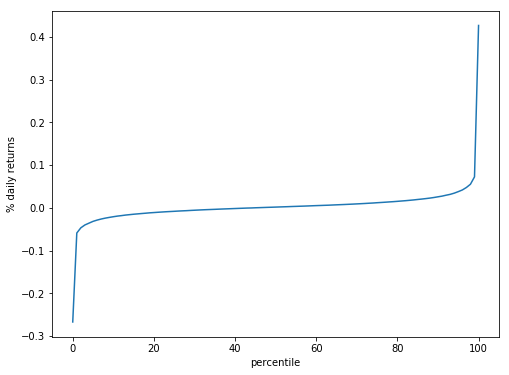

In [215]:
plt.plot(percentile)
plt.xlabel("percentile")
plt.ylabel("% daily returns")
plt.show()

Now each stock is mapped to the etfs that it is top 40 member of

In [415]:
mapping_dict = {}

for etf in etfs_list[2:]:
    for stock in vars()[etf + '_stocks']:
        if stock in mapping_dict:
            mapping_dict[stock].append(etf)
        else:
            mapping_dict[stock] = [etf]

In [217]:
mapping_dict

{'NEE': ['XLU'],
 'DUK': ['XLU'],
 'D': ['XLU'],
 'SO': ['XLU'],
 'EXC': ['XLU'],
 'AEP': ['XLU'],
 'SRE': ['XLU'],
 'PEG': ['XLU'],
 'XEL': ['XLU'],
 'ED': ['XLU'],
 'WEC': ['XLU'],
 'ES': ['XLU'],
 'DTE': ['XLU'],
 'PPL': ['XLU'],
 'FE': ['XLU'],
 'AWK': ['XLU'],
 'EIX': ['XLU'],
 'ETR': ['XLU'],
 'AEE': ['XLU'],
 'CMS': ['XLU'],
 'EVRG': ['XLU'],
 'CNP': ['XLU'],
 'ATO': ['XLU'],
 'LNT': ['XLU'],
 'AES': ['XLU'],
 'PNW': ['XLU'],
 'NI': ['XLU'],
 'NRG': ['XLU'],
 'FB': ['VOX'],
 'GOOG': ['VOX'],
 'GOOGL': ['VOX'],
 'VZ': ['VOX'],
 'CMCSA': ['VOX'],
 'DIS': ['VOX'],
 'T': ['VOX'],
 'NFLX': ['VOX'],
 'CHTR': ['VOX'],
 'TMUS': ['VOX'],
 'ATVI': ['VOX'],
 'EA': ['VOX'],
 'TWTR': ['VOX'],
 'LBTYK': ['VOX'],
 'LBRDA': ['VOX'],
 'ZAYO': ['VOX'],
 'DISCK': ['VOX'],
 'OMC': ['VOX'],
 'IAC': ['VOX'],
 'S': ['VOX'],
 'Z': ['VOX'],
 'CBS': ['VOX'],
 'TTWO': ['VOX'],
 'FOXA': ['VOX'],
 'CTL': ['VOX'],
 'FWONK': ['VOX'],
 'VIAB': ['VOX'],
 'LYV': ['VOX'],
 'IPG': ['VOX'],
 'SIRI': ['VOX'],
 'DISH

## Models

The purpose of this assignment is to compare the performance of robust regression penalty functions to the performance of Ordinary Least Squares penalty function. Robust penalty functions are often able to outperform the OLS penalty functions because they are able to identify the outliers and penalize them to get the better and realistic estimate of the paramaters. The three models that we are going to compare here are - 

- `OLS`
- `Huber`
- `Tukey Bisquare`

We define the linear model of stock daily returns on the daily returns of SPY, QQQ and all the ETFs that the stock is top 40 member of. The linear regression is run using OLS, Huber & Tukey penalty functions.  

$r_S$ ~ $\beta_0 + \beta_1 * r_{SPY} + \beta_2 * r_{QQQ} + \beta_3 * r_{ETF_1} + ...$

The function `build_models` takes three parameters and it computes 6 models which are OLS without intercept, OLS with intercept, Huber without intercept, Huber with intercept, Tukey without intercept and Tukey with intercept. The regression is run on first 30 days of daily returns.  

- `Huber parameter` : the scale parameter of huber penalty function (float)
- `Tukey parameter` : the scale parameter of tukey bisquare penalty function (float)
- `Progress bar` : whether we want to show progress bar (boolean)

And it returns two values - 

- First is a list of 6 lists, each nested list contains fitted models for all the stocks for each of the 6 models. The model has four important parameters attached to it
    1. `model.model.endog` : the in-sample dependent variables
    2. `model.oos_endog` : the out-of-sample dependent variables
    3. `model.resid` : the in-sample residuals
    4. `model.oos_resid` : the out-of-sample residuals


- Second is an array of two lists, first list contains the time it takes to fit the models for each of the 6 models, second list contains the time it takes to predict for eac model

In [218]:
def build_models(huber_param, tukey_param, progress_bar=True):
    ols_models = []
    ols_models_intercept = []
    
    huber_models = []
    huber_models_intercept = []
    
    tukey_models = []
    tukey_models_intercept = []
    
    time_fitting = np.array([0.] * 6)
    time_prediction = np.array([0.] * 6)
    
    def oos_prediction(model, y_oos, X_oos):
        y_pred = model.predict(X_oos)
        resid = y_pred - y_oos
        model.oos_resid = resid
        model.oos_endog = y_oos
        return
    
    for stock in tqdm(stocks_list, ncols=100, desc="FITTING MODELS", disable=not progress_bar):
        
        times = []
        
        y = data[stock][:30]
        X = data[['SPY', 'QQQ'] + mapping_dict[stock]][:30]
        
        times.append(time.time())
        
        ols_models.append(OLS(y, X).fit())
        times.append(time.time())
        
        ols_models_intercept.append(OLS(y, add_constant(X)).fit())
        times.append(time.time())
        
        huber_models.append(RLM(y, X, M=HuberT(huber_param)).fit())
        times.append(time.time())
        
        huber_models_intercept.append(RLM(y, add_constant(X), M=HuberT(huber_param)).fit())
        times.append(time.time())
        
        tukey_models.append(RLM(y, X, M=TukeyBiweight(tukey_param)).fit())
        times.append(time.time())
        
        tukey_models_intercept.append(RLM(y, add_constant(X), M=TukeyBiweight(tukey_param)).fit())
        times.append(time.time())
        
        time_fitting += np.diff(times)
        
    for i, stock in enumerate(tqdm(stocks_list, ncols=100, desc="PREDICTING MODELS", disable=not progress_bar)):
        
        times = []
        
        y_oos = data[stock][31:]
        X_oos = data[['SPY', 'QQQ'] + mapping_dict[stock]][31:]
        
        times.append(time.time())
        
        oos_prediction(ols_models[i], y_oos, X_oos)
        times.append(time.time())
        
        oos_prediction(ols_models_intercept[i], y_oos, add_constant(X_oos))
        times.append(time.time())
        
        oos_prediction(huber_models[i], y_oos, X_oos)
        times.append(time.time())
        
        oos_prediction(huber_models_intercept[i], y_oos, add_constant(X_oos))
        times.append(time.time())
        
        oos_prediction(tukey_models[i], y_oos, X_oos)
        times.append(time.time())
        
        oos_prediction(tukey_models_intercept[i], y_oos, add_constant(X_oos))
        times.append(time.time())
        
        time_prediction += np.diff(times)
    
    return [ols_models, ols_models_intercept, huber_models, huber_models_intercept, tukey_models, 
            tukey_models_intercept], np.array([time_fitting, time_prediction])

#### R-squared

R-squared is calculated using below formula 

$$\text{R_squared} = 1 - \frac{\text{SSResidual}}{\text{SSTotal}}$$


In [242]:
def r_squared(model, oos):
    if oos == True:
        y = model.oos_endog
        resid = model.oos_resid
    else:
        y = model.model.endog
        resid = model.resid
    sst = np.sum(np.power(y - y.mean(), 2))
    ssr = np.sum(resid*resid)
    return 1 - ssr/sst

We are first going to run the models for the default value of the paramaters. We calculate both in-sample and out-of-sample R_squared for each model type and make a bar plot. Then we plot the fitting and prediction time for each model type.

In [267]:
models_, time_ = build_models(1.345, 4.685, True)


FITTING MODELS:  61%|███████████████████████████▏                 | 175/289 [00:09<00:06, 18.05it/s]


FITTING MODELS:  83%|█████████████████████████████████████▌       | 241/289 [00:03<00:00, 66.69it/s]


FITTING MODELS: 100%|█████████████████████████████████████████████| 289/289 [00:04<00:00, 68.47it/s]

In [221]:
R2 = [np.mean(([r_squared(model, False) for model in models])) for models in models_]
R2_oos = [np.mean(([r_squared(model, True) for model in models])) for models in models_]

In [222]:
model_names = ["OLS", "OLS_intercept", "Huber", "Huber_intercept", "Tukey", "Tukey_intercept"]
result = pd.DataFrame([R2, R2_oos], columns=model_names, index=["R2", "R2_OOS"])

In [223]:
result

,OLS,OLS_intercept,Huber,Huber_intercept,Tukey,Tukey_intercept
R2,0.524441,0.543677,0.511891,0.527476,0.497015,0.507857
R2_OOS,0.177905,0.090236,0.245493,0.191038,0.260109,0.208721


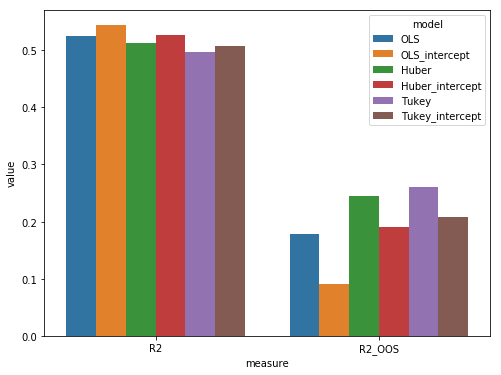

In [224]:
result_plot = result.reset_index().melt("index")
result_plot.columns = ['measure', 'model', 'value']
sns.barplot(x="measure", y="value", hue="model", data=result_plot)

In [225]:
time_result = pd.DataFrame(time_, columns=model_names, index=["Fitting", "Prediction"])

In [226]:
time_result

,OLS,OLS_intercept,Huber,Huber_intercept,Tukey,Tukey_intercept
Fitting,0.279793,1.186032,2.901954,3.915104,1.571253,2.671256
Prediction,0.118623,0.986675,0.095159,0.987778,0.094396,0.939656


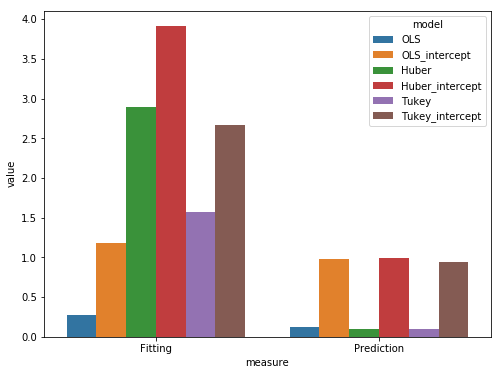

In [227]:
time_result_plot = time_result.reset_index().melt("index")
time_result_plot.columns = ['measure', 'model', 'value']
sns.barplot(x="measure", y="value", hue="model", data=time_result_plot)

#### Findings so far

- Model performance measured by R-squared
    - Looking at the first bar plot, we see that the in-sample R_squared is best for OLS but it performs worst in out-of-sample scenario. This might be because the OLS is overfitting the data due to its penalty function which penalizes true data points and the outliers equally. The huber and Tukey have smaller R_squared in-sample and better R_squared out-of-sample meaning that they are less influenced by outliers and give a better approximation of true underlying distribution. 
    - Out-of-sample performance is much worse than in-sample for all the three models indicating overfitting.

- Model performance measured by fitting times
    - Looking the second bar plot, we notice that huber takes more time to fit the models as compared to OLS and Tukey. OLS is the best in this case. 
    - Prediction takes much less time as compared to fitting, so we can ignore that.

Next we take 50 parameters from 0.01 upto 10 and compute each model for these parameters. We will plot in-sample R_squared, out-of-sample R_squared and fitting time for all six models as a function of parameters.

In [234]:
if os.path.isfile("params_results.dill"):
    with open("params_results.dill", "br") as f:
        params_list, models_list, times_list = dill.load(f)
    print("Results loaded from params_results.dll file")
else:
    params_list = np.linspace(0.01, 10, num=50)
    
    models_list = []
    times_list = []
    
    for p in tqdm(params_list, ncols=100, desc="Total Progress"):
        m, t = build_models(p, p, False)
        models_list.append(m)
        times_list.append(t)
    
    with open("params_results.dill", "bw") as f:
        dill.dump([params_list, models_list, times_list], f)
    print("Results written to params_results.ddl file")

Results loaded from params_results.dll file


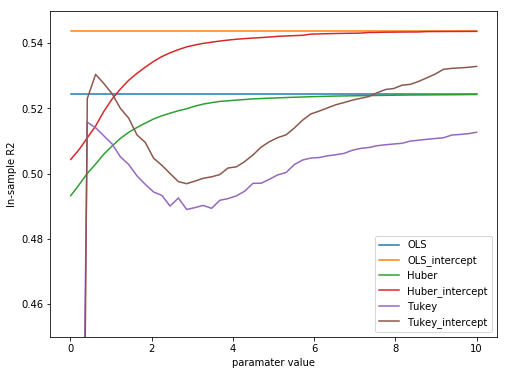

In [252]:
for i in range(0, 6):
    plt.plot(params_list, [np.mean([r_squared(model, False) for model in models[i]]) for models in models_list],
            label=model_names[i])

plt.legend()
plt.ylim(0.45, 0.55)
plt.xlabel("paramater value")
plt.ylabel("In-sample R2")
plt.show()

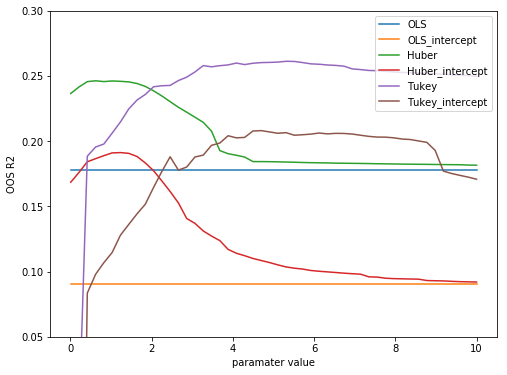

In [255]:
for i in range(0, 6):
    plt.plot(params_list, [np.mean([r_squared(model, True) for model in models[i]]) for models in models_list],
            label=model_names[i])

plt.legend()
plt.ylim(0.05, 0.3)
plt.xlabel("paramater value")
plt.ylabel("OOS R2")
plt.show()

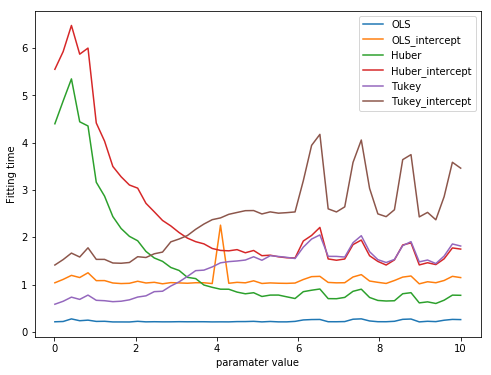

In [261]:
for i in range(0, 6):
    plt.plot(params_list, [times[0][i] for times in times_list], label=model_names[i])

plt.legend()
plt.xlabel("paramater value")
plt.ylabel("Fitting time")
plt.show()

Based on the plots above, we have the following observations - 

#### In sample findings : 
- As the parameter increases, R_squared for Huber increases and approaches the OLS for larger parameter values.
    - The inference is that for the smaller parameter values, Huber is penalizing the outliers more than OLS or we can say Huber is less overfit than OLS in-sample. As parameter increases, the outliers are able to influence the regression parameters as most of them lie within the boundary of OLS-like penalty.
    
- The same thing is happening with tukey bisquare. As the parameter increases, R_squared increases and approaches the OLS for larger parameter values. For the parameter values between 1 to 4, R_squared is lower than expected.
    - For very small parameter (close to 0) Tukey behaves weird because the derivative of penalty function is zero throughout, therefore the sudden increase in the beginning. Then there is a drop, my understanding is that in this interval, Tukey penalty function is ignoring some true datapoints along with the outliers, consequently underestimating the true regression parameters. For larger parameters, it is including too many outliers in the normal penalty zone. 
    
#### Out of sample findings :
- For Huber, R_squared for smaller parameters is higher and approaches OLS as parameter value increases. Maximum performance is achieved between 1 to 2. 
    - For smaller parameter Huber is less overfit in-sample and therefore performs better out of sample. As parameter value increases, it behaves more like OLS as most of the outliers fall within the boundary of OLS-like penalty.
    
- For Tukey maximum R_squared is achieved between 3 to 6 and goes down as paramter increases further. 
    - Maximum R_squared for parameters between 3 to 6 suggests that the model is neither underfit nor overfit in-sample, therefore representing the best possible underlying distribution and giving best performance out of sample. For higher values, it behaves more like OLS as most of the outliers fall within the boundary of OLS-like penalty and model is likely overfit in sample.
    
#### Computation time 
- Computation time is higher for smaller parameters for Huber and decreases as parameter increases, while it is opposite for Tukey.
    

As we see from the above plots that Huber if performing best at around 1.4 and Tukey is performing best at around 5, we will compute the models for these parameters again and plot the statistics.

In [416]:
models_, times_ = build_models(1.4, 5, False)

In [417]:
R2 = [np.mean(([r_squared(model, False) for model in models])) for models in models_]
R2_oos = [np.mean(([r_squared(model, True) for model in models])) for models in models_]

In [418]:
model_names = ["OLS", "OLS_intercept", "Huber", "Huber_intercept", "Tukey", "Tukey_intercept"]
result = pd.DataFrame([R2, R2_oos], columns=model_names, index=["R2", "R2_OOS"])
result

,OLS,OLS_intercept,Huber,Huber_intercept,Tukey,Tukey_intercept
R2,0.524441,0.543677,0.512382,0.528181,0.499213,0.510292
R2_OOS,0.177905,0.090236,0.245429,0.190877,0.260409,0.206140


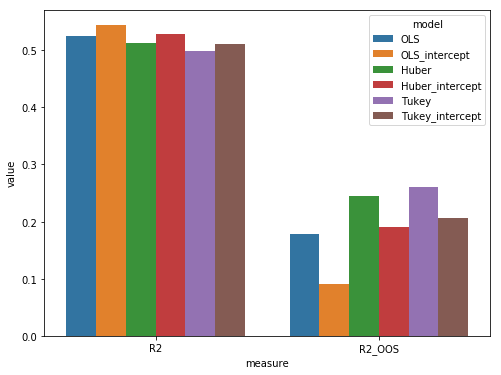

In [419]:
result_plot = result.reset_index().melt("index")
result_plot.columns = ['measure', 'model', 'value']
sns.barplot(x="measure", y="value", hue="model", data=result_plot)

In [420]:
time_result = pd.DataFrame(time_, columns=model_names, index=["Fitting", "Prediction"])
time_result

,OLS,OLS_intercept,Huber,Huber_intercept,Tukey,Tukey_intercept
Fitting,0.331027,1.329205,3.363165,4.737061,1.939581,3.020774
Prediction,0.135491,1.114832,0.109419,1.061471,0.104613,1.051887


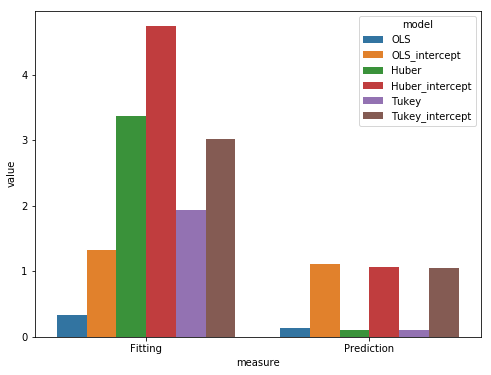

In [421]:
time_result_plot = time_result.reset_index().melt("index")
time_result_plot.columns = ['measure', 'model', 'value']
sns.barplot(x="measure", y="value", hue="model", data=time_result_plot)

For parameters 1.4 (Huber) & 5 (Tukey), we will check the best model for each stock. 

In [290]:
r2_oos = np.array([[r_squared(model, True) for model in models] for models in models_])

In [292]:
best_model = []

for i in range(len(stocks_list)):
    best_model.append(np.argmax(r2_oos[:, i]))
    
best_model = np.array(best_model)

In [319]:
print("For %.2f %% stocks, best model is OLS without intercept" % (np.sum(best_model == 0)*100/len(stocks_list)))
print("Stocks list: ", np.array(stocks_list)[best_model == 0])

print("For %.2f %% stocks, best model is OLS with intercept" % (np.sum(best_model == 1)*100/len(stocks_list)))
print("Stocks list: ", np.array(stocks_list)[best_model == 1])

print("For %.2f %% stocks, best model is Huber without intercept" % (np.sum(best_model == 2)*100/len(stocks_list)))
print("Stocks list: ", np.array(stocks_list)[best_model == 2])

print("For %.2f %% stocks, best model is Huber with intercept" % (np.sum(best_model == 3)*100/len(stocks_list)))
print("Stocks list: ", np.array(stocks_list)[best_model == 3])

print("For %.2f %% stocks, best model is Tukey without intercept" % (np.sum(best_model == 4)*100/len(stocks_list)))
print("Stocks list: ", np.array(stocks_list)[best_model == 4])

print("For %.2f %% stocks, best model is Tukey with intercept" % (np.sum(best_model == 5)*100/len(stocks_list)))
print("Stocks list: ", np.array(stocks_list)[best_model == 5])

print("\n\nIN TOTAL, ROBUST MODELS PERFORM BEST FOR {:.3%} OF TICKERS.".format(
    1-np.sum([best_model == 0] + [best_model == 1]) / len(best_model)))

For 28.37 % stocks, best model is OLS without intercept
Stocks list:  ['TMUS' 'BLUE' 'IPG' 'TSCO' 'DO' 'ES' 'PTCT' 'SNAP' 'QCOM' 'PSX' 'NBIX'
 'AES' 'SPGI' 'SO' 'IAC' 'FWONK' 'DUK' 'ED' 'ARNA' 'VRTX' 'AZO' 'D' 'GBT'
 'AEO' 'HUM' 'OII' 'PPL' 'WMT' 'ARRY' 'UTHR' 'CERN' 'ETR' 'CTL' 'AMAT'
 'NXPI' 'ON' 'SWN' 'SIRI' 'AON' 'PNW' 'COST' 'BLK' 'BHVN' 'CJ' 'GCO'
 'GOOGL' 'PTEN' 'XEC' 'CNP' 'ALL' 'ZBH' 'MRVL' 'TROW' 'BOOT' 'SLB' 'VIAB'
 'CNC' 'ASML' 'NFLX' 'GOOG' 'CASY' 'ESV' 'OLLI' 'FANG' 'PTLA' 'PNC' 'CABO'
 'BK' 'BMRN' 'USB' 'SGEN' 'WLL' 'DTE' 'CDEV' 'EXC' 'LBTYK' 'CB' 'AMP'
 'WFTIF' 'GPI' 'HCA' 'IQV']
For 16.26 % stocks, best model is OLS with intercept
Stocks list:  ['EOG' 'SLCA' 'BBY' 'PXD' 'FTI' 'KLAC' 'RCII' 'PEG' 'TRV' 'PE' 'ANAB'
 'WLTW' 'LGND' 'BHGE' 'S' 'CLR' 'TTWO' 'ATVI' 'OAS' 'FE' 'BAX' 'VKTX'
 'ICE' 'RES' 'PDCE' 'GRPN' 'MXIM' 'RARE' 'STM' 'CMCSA' 'ACAD' 'BURL' 'NBL'
 'XOM' 'NOV' 'Z' 'IMMU' 'REGN' 'FB' 'MET' 'NBR' 'MPC' 'TXN' 'MRO' 'NE'
 'TWTR' 'ABG']
For 13.49 % stocks, best mode

#### Distribution of residuals

We compute three types of residuals and plot their distribution in the following cells - 

- in-sample residuals
- out-of-sample residuals
- out-of-sample residuals normalized by in-sample residual standard deviation

The distribution is compared against the normal distribution. It is clear that the residuals distribution deviates from the normal distribution. It has higher peaks and fatter tails. It also explains why OLS does not do well out-of-sample. As the underlying assumption of OLS is that the residuals are i.i.d and normally distributed. In reality, this assumption is not followed, therefore poor performance by OLS.

In [383]:
in_resid = np.array([[model.resid for model in models] for models in models_])
oos_resid = np.array([[model.oos_resid for model in models] for models in models_])
norm_oos_resid = np.array([[model.oos_resid/model.resid.std() for model in models] for models in models_])

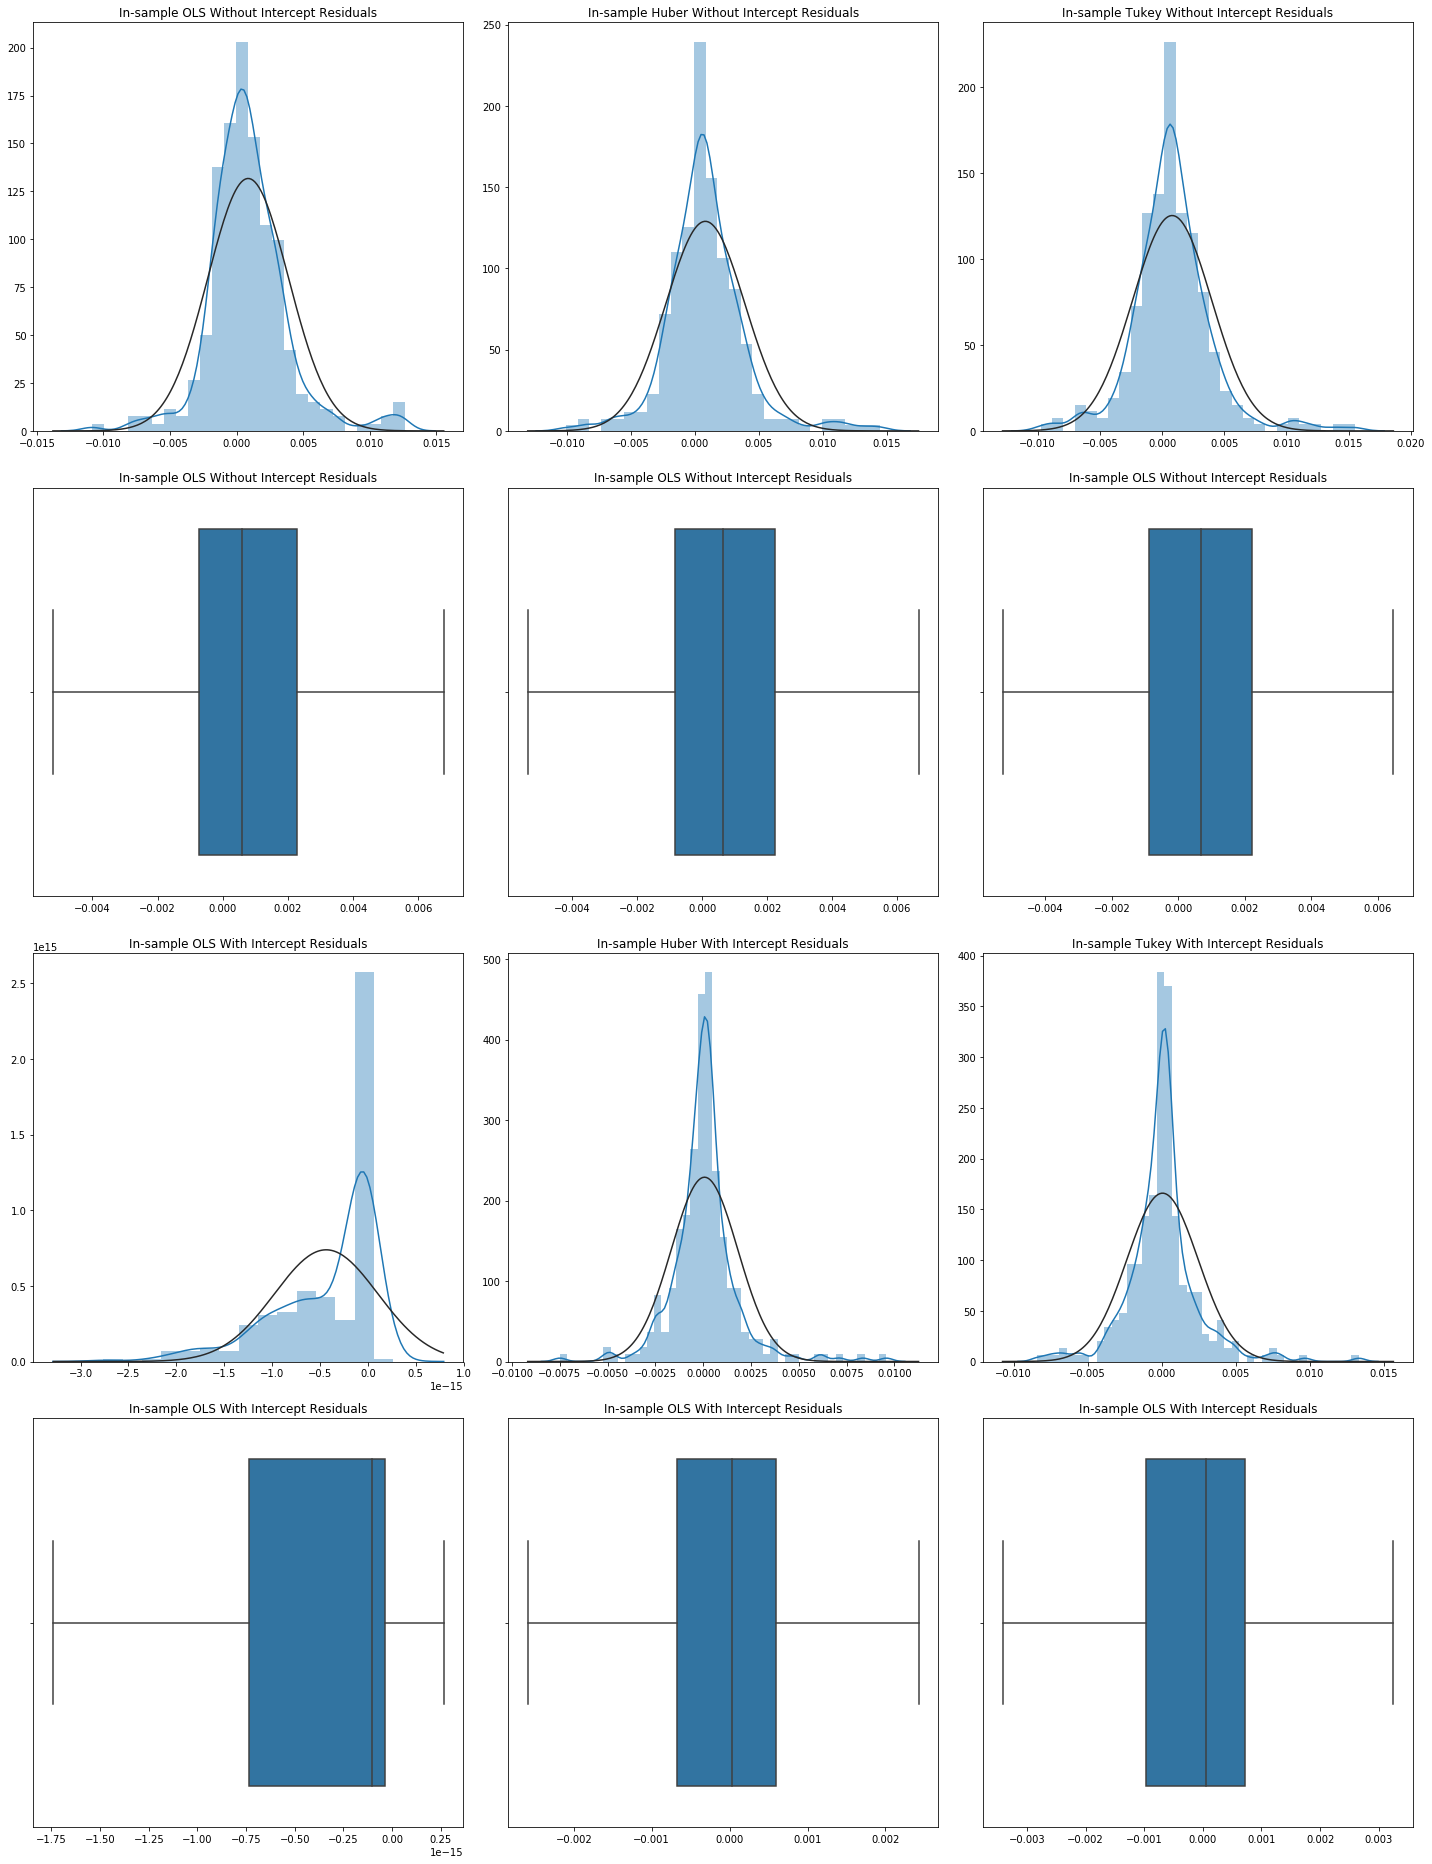

In [384]:
fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(20, 26))
sns.distplot(np.mean(in_resid[0], axis=1), ax=axs[0][0], fit=norm).set_title("In-sample OLS Without Intercept Residuals")
sns.distplot(np.mean(in_resid[2], axis=1), ax=axs[0][1], fit=norm).set_title("In-sample Huber Without Intercept Residuals")
sns.distplot(np.mean(in_resid[4], axis=1), ax=axs[0][2], fit=norm).set_title("In-sample Tukey Without Intercept Residuals")
sns.boxplot(np.mean(in_resid[0], axis=1), ax=axs[1][0], showfliers=False).set_title("In-sample OLS Without Intercept Residuals")
sns.boxplot(np.mean(in_resid[2], axis=1), ax=axs[1][1], showfliers=False).set_title("In-sample OLS Without Intercept Residuals")
sns.boxplot(np.mean(in_resid[4], axis=1), ax=axs[1][2], showfliers=False).set_title("In-sample OLS Without Intercept Residuals")

sns.distplot(np.mean(in_resid[1], axis=1), ax=axs[2][0], fit=norm).set_title("In-sample OLS With Intercept Residuals")
sns.distplot(np.mean(in_resid[3], axis=1), ax=axs[2][1], fit=norm).set_title("In-sample Huber With Intercept Residuals")
sns.distplot(np.mean(in_resid[5], axis=1), ax=axs[2][2], fit=norm).set_title("In-sample Tukey With Intercept Residuals")
sns.boxplot(np.mean(in_resid[1], axis=1), ax=axs[3][0], showfliers=False).set_title("In-sample OLS With Intercept Residuals")
sns.boxplot(np.mean(in_resid[3], axis=1), ax=axs[3][1], showfliers=False).set_title("In-sample OLS With Intercept Residuals")
sns.boxplot(np.mean(in_resid[5], axis=1), ax=axs[3][2], showfliers=False).set_title("In-sample OLS With Intercept Residuals")

plt.tight_layout()

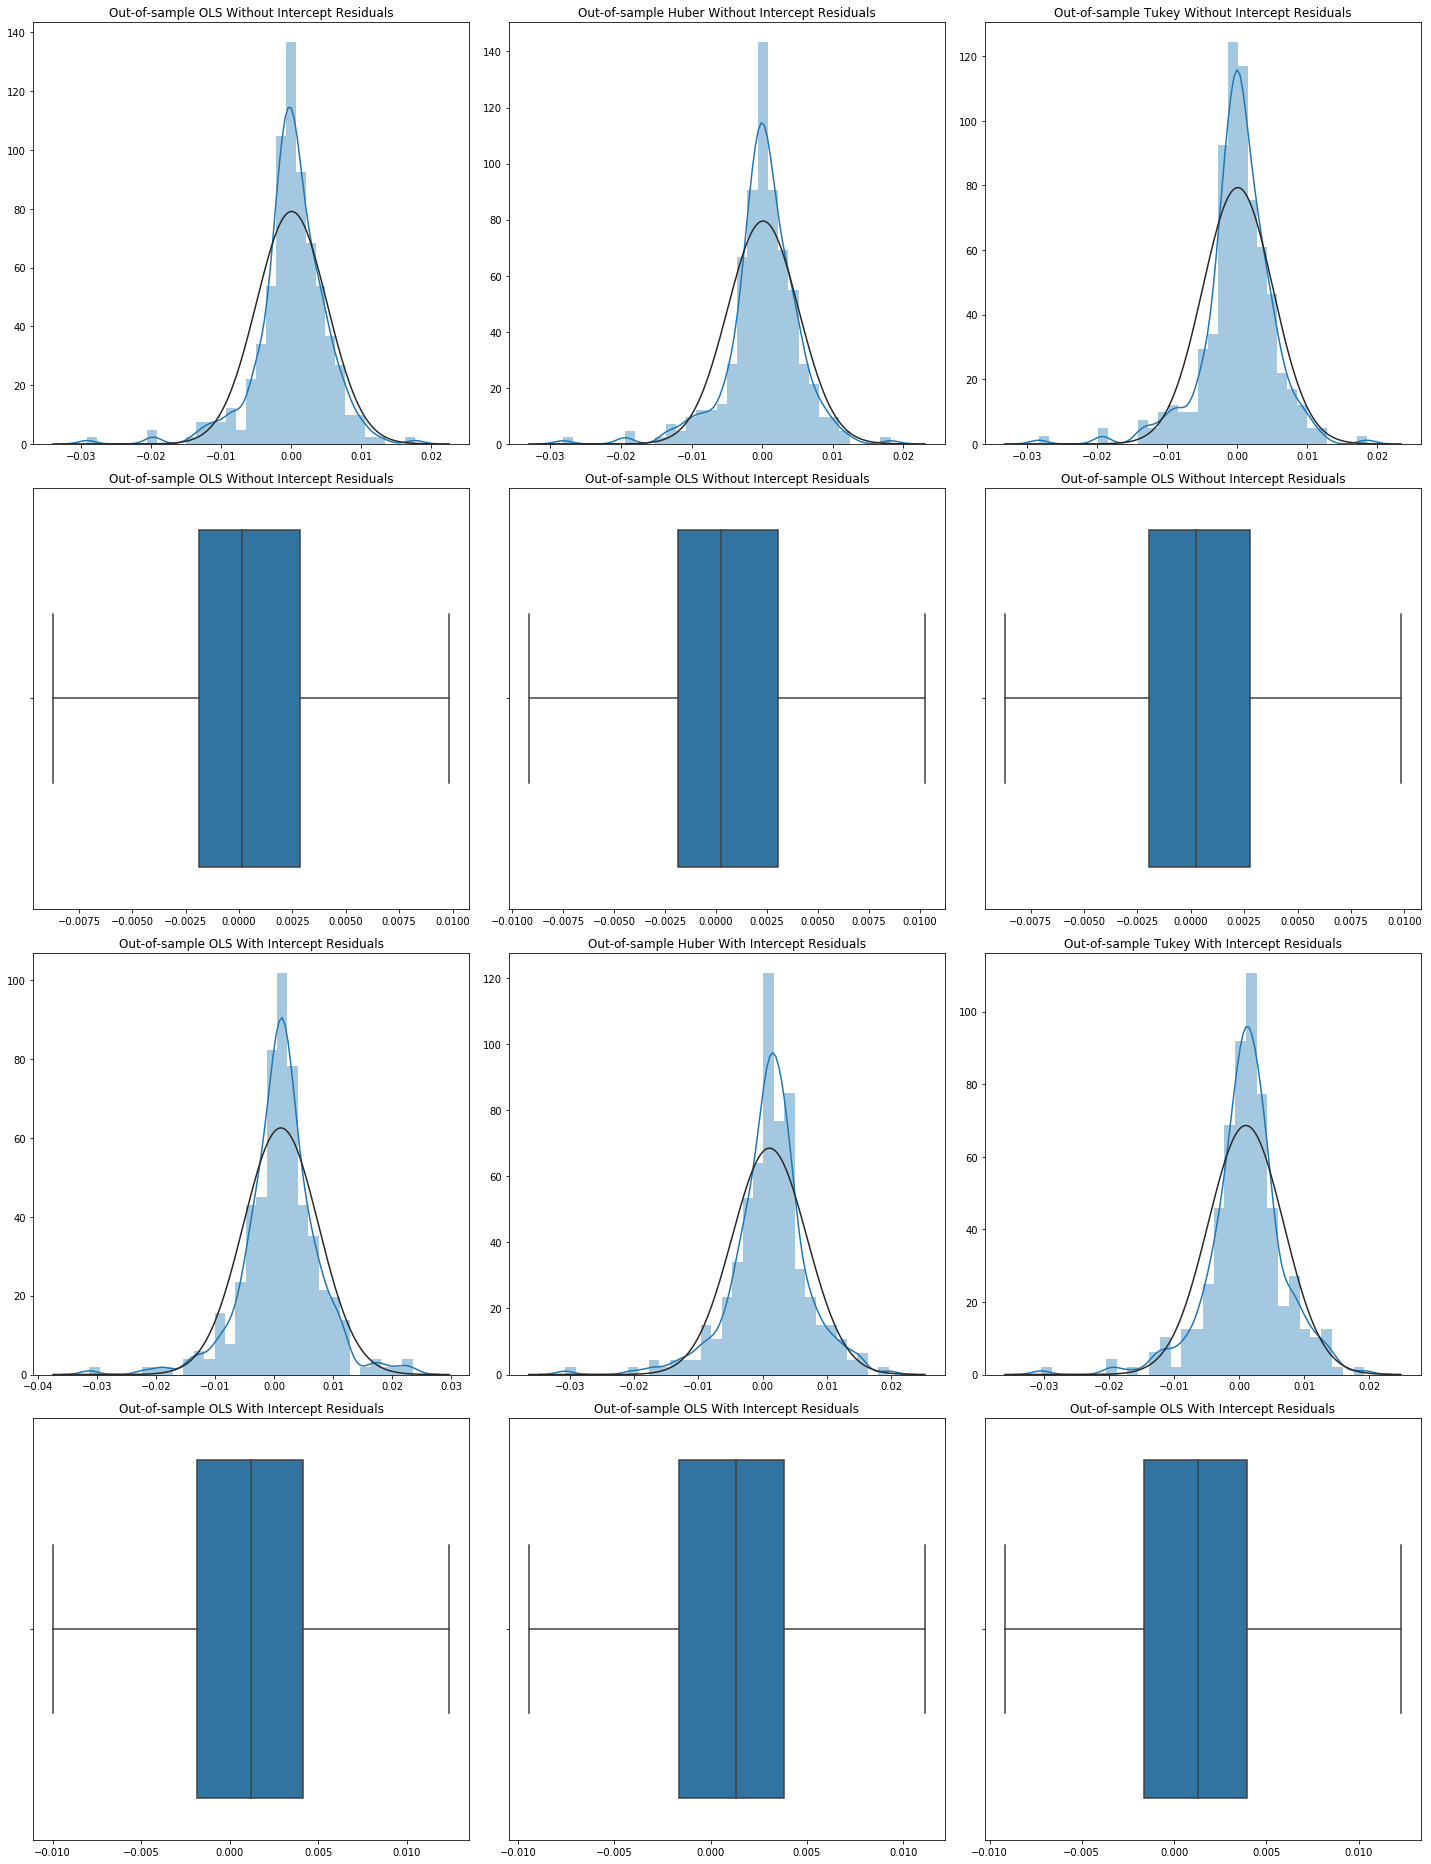

In [381]:
fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(20, 26))
sns.distplot(np.mean(oos_resid[0], axis=1), ax=axs[0][0], fit=norm).set_title("Out-of-sample OLS Without Intercept Residuals")
sns.distplot(np.mean(oos_resid[2], axis=1), ax=axs[0][1], fit=norm).set_title("Out-of-sample Huber Without Intercept Residuals")
sns.distplot(np.mean(oos_resid[4], axis=1), ax=axs[0][2], fit=norm).set_title("Out-of-sample Tukey Without Intercept Residuals")
sns.boxplot(np.mean(oos_resid[0], axis=1), ax=axs[1][0], showfliers=False).set_title("Out-of-sample OLS Without Intercept Residuals")
sns.boxplot(np.mean(oos_resid[2], axis=1), ax=axs[1][1], showfliers=False).set_title("Out-of-sample OLS Without Intercept Residuals")
sns.boxplot(np.mean(oos_resid[4], axis=1), ax=axs[1][2], showfliers=False).set_title("Out-of-sample OLS Without Intercept Residuals")

sns.distplot(np.mean(oos_resid[1], axis=1), ax=axs[2][0], fit=norm).set_title("Out-of-sample OLS With Intercept Residuals")
sns.distplot(np.mean(oos_resid[3], axis=1), ax=axs[2][1], fit=norm).set_title("Out-of-sample Huber With Intercept Residuals")
sns.distplot(np.mean(oos_resid[5], axis=1), ax=axs[2][2], fit=norm).set_title("Out-of-sample Tukey With Intercept Residuals")
sns.boxplot(np.mean(oos_resid[1], axis=1), ax=axs[3][0], showfliers=False).set_title("Out-of-sample OLS With Intercept Residuals")
sns.boxplot(np.mean(oos_resid[3], axis=1), ax=axs[3][1], showfliers=False).set_title("Out-of-sample OLS With Intercept Residuals")
sns.boxplot(np.mean(oos_resid[5], axis=1), ax=axs[3][2], showfliers=False).set_title("Out-of-sample OLS With Intercept Residuals")

plt.tight_layout()

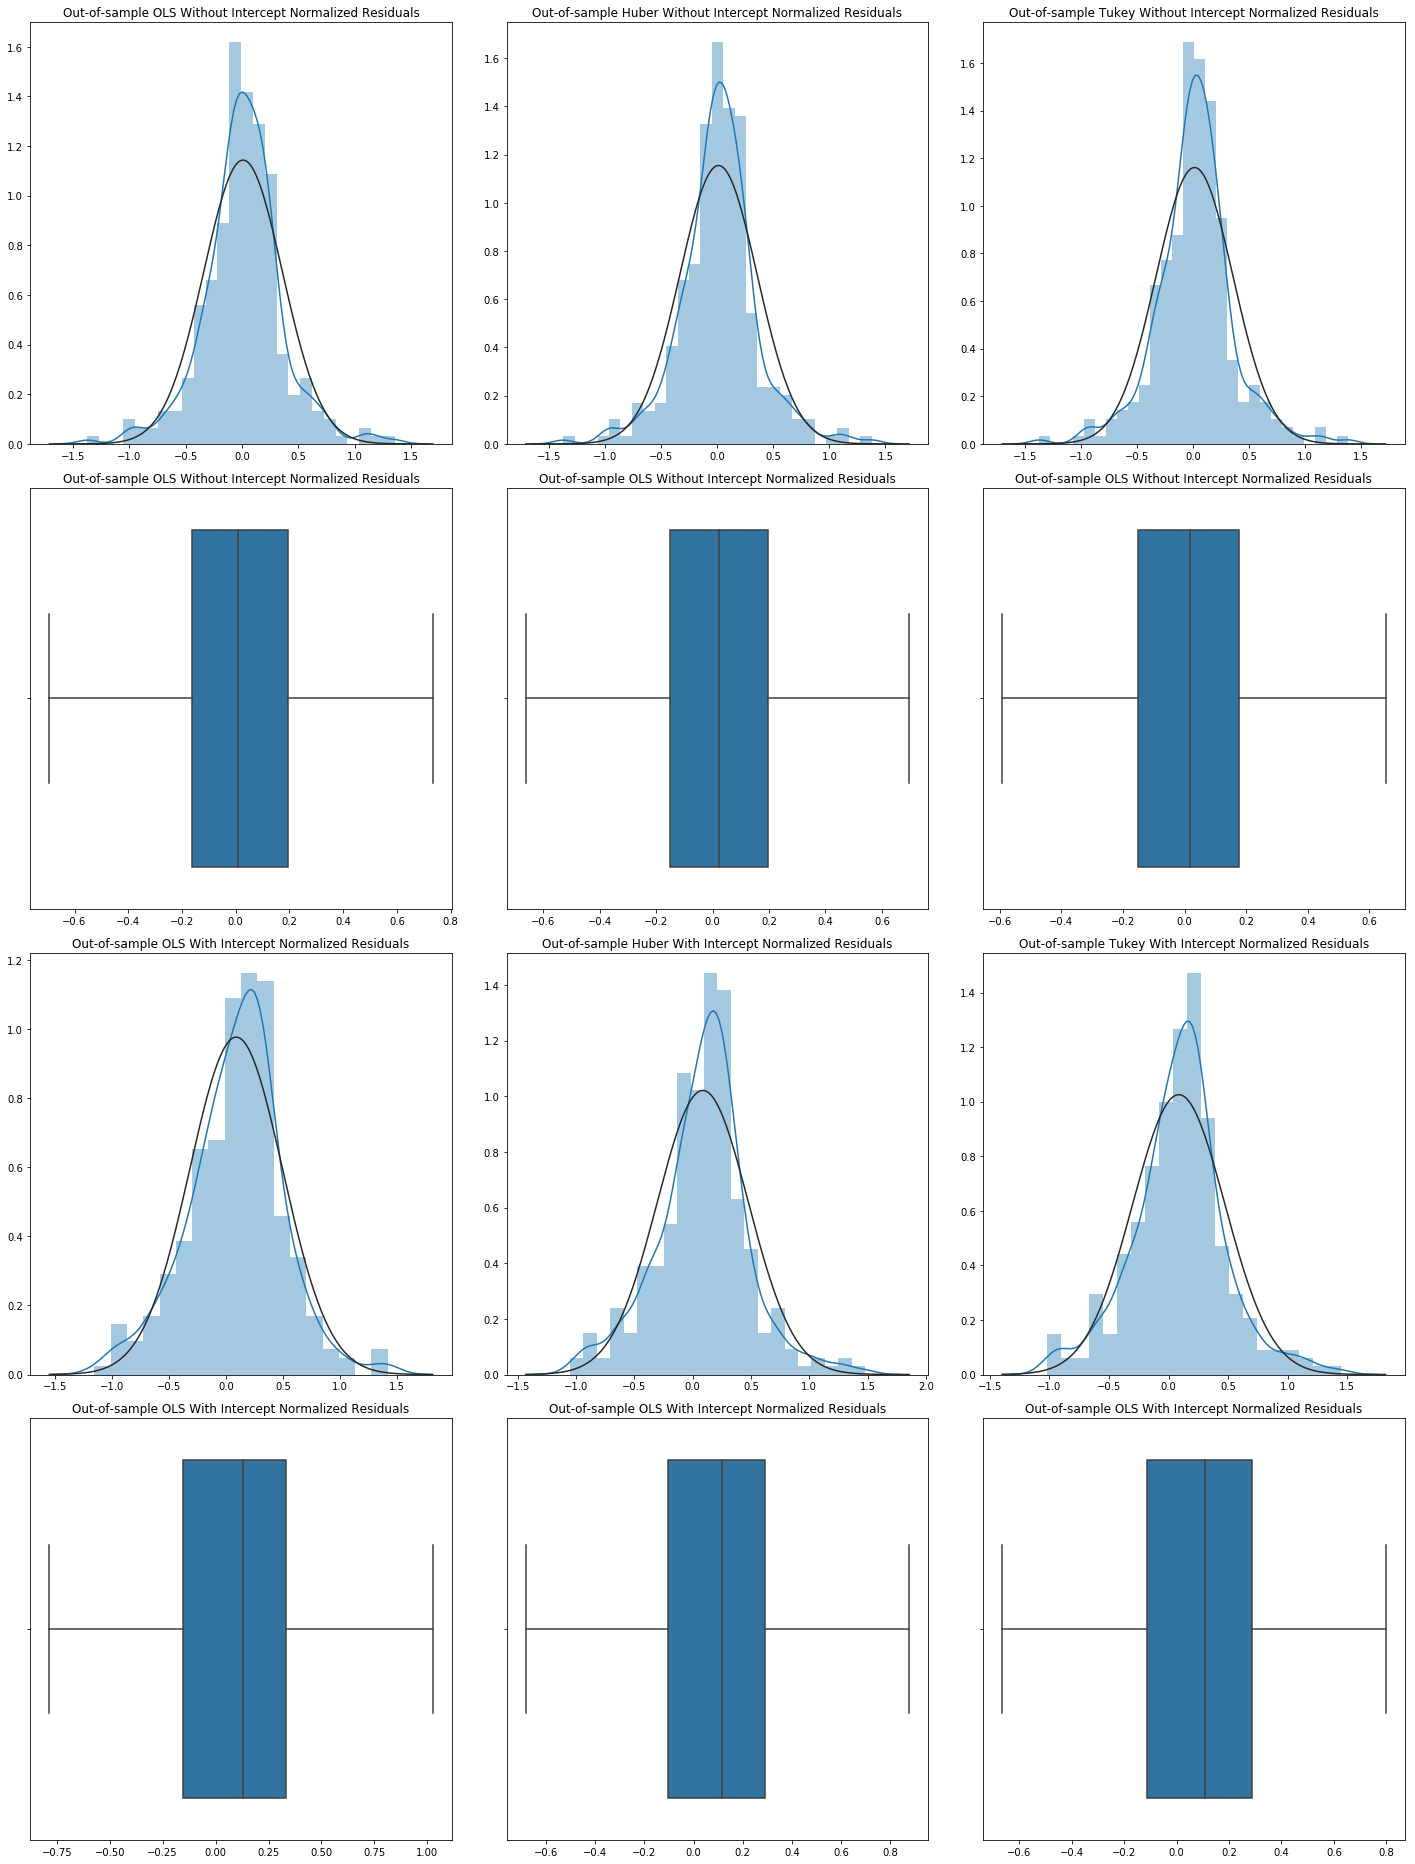

In [382]:
fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(20, 26))
sns.distplot(np.mean(norm_oos_resid[0], axis=1), ax=axs[0][0], fit=norm).set_title("Out-of-sample OLS Without Intercept Normalized Residuals")
sns.distplot(np.mean(norm_oos_resid[2], axis=1), ax=axs[0][1], fit=norm).set_title("Out-of-sample Huber Without Intercept Normalized Residuals")
sns.distplot(np.mean(norm_oos_resid[4], axis=1), ax=axs[0][2], fit=norm).set_title("Out-of-sample Tukey Without Intercept Normalized Residuals")
sns.boxplot(np.mean(norm_oos_resid[0], axis=1), ax=axs[1][0], showfliers=False).set_title("Out-of-sample OLS Without Intercept Normalized Residuals")
sns.boxplot(np.mean(norm_oos_resid[2], axis=1), ax=axs[1][1], showfliers=False).set_title("Out-of-sample OLS Without Intercept Normalized Residuals")
sns.boxplot(np.mean(norm_oos_resid[4], axis=1), ax=axs[1][2], showfliers=False).set_title("Out-of-sample OLS Without Intercept Normalized Residuals")

sns.distplot(np.mean(norm_oos_resid[1], axis=1), ax=axs[2][0], fit=norm).set_title("Out-of-sample OLS With Intercept Normalized Residuals")
sns.distplot(np.mean(norm_oos_resid[3], axis=1), ax=axs[2][1], fit=norm).set_title("Out-of-sample Huber With Intercept Normalized Residuals")
sns.distplot(np.mean(norm_oos_resid[5], axis=1), ax=axs[2][2], fit=norm).set_title("Out-of-sample Tukey With Intercept Normalized Residuals")
sns.boxplot(np.mean(norm_oos_resid[1], axis=1), ax=axs[3][0], showfliers=False).set_title("Out-of-sample OLS With Intercept Normalized Residuals")
sns.boxplot(np.mean(norm_oos_resid[3], axis=1), ax=axs[3][1], showfliers=False).set_title("Out-of-sample OLS With Intercept Normalized Residuals")
sns.boxplot(np.mean(norm_oos_resid[5], axis=1), ax=axs[3][2], showfliers=False).set_title("Out-of-sample OLS With Intercept Normalized Residuals")

plt.tight_layout()

Next we make QQ plots for normalized oos residuals against normal distribution. As we can see that the quantile values are deviating from the red lines, reinforcing the fact that the true residual distribution has fatter tails.  

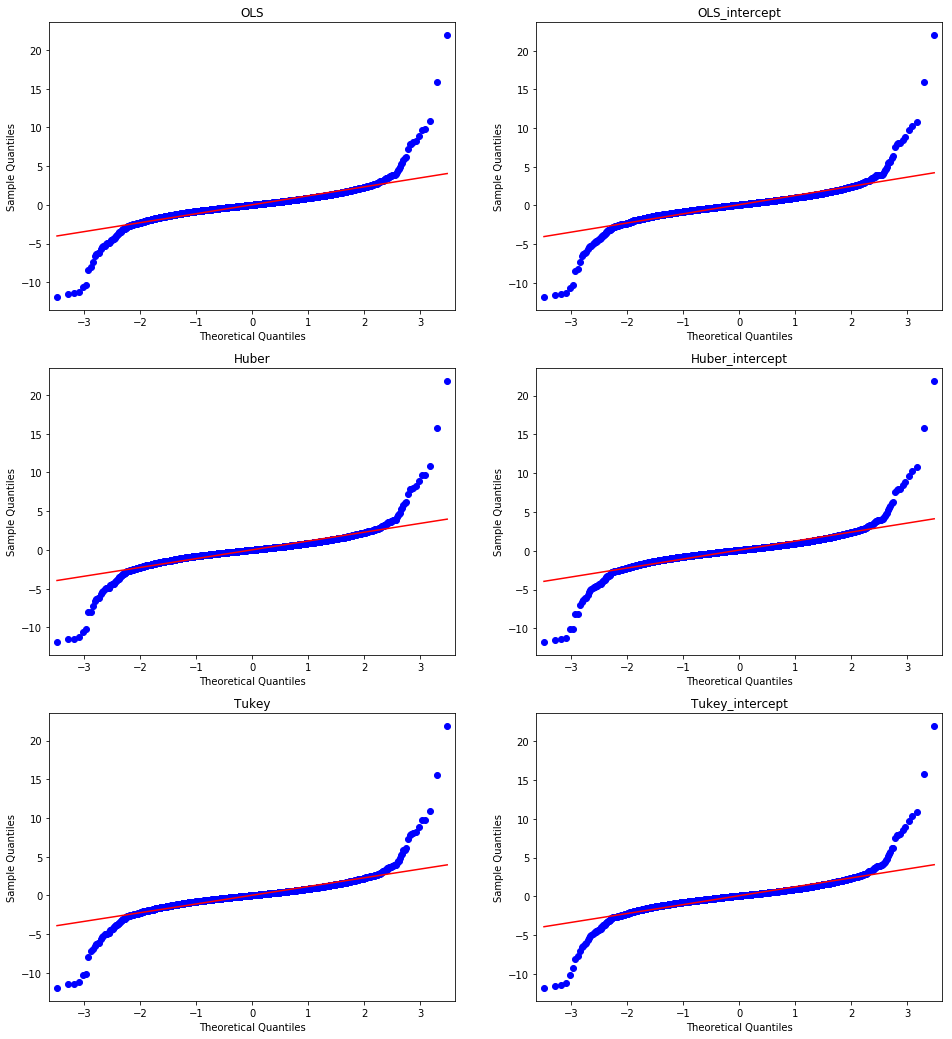

In [396]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(16, 18))
ax = ax.flatten()

for i in range(6):
    qqplot(norm_oos_resid[i].flatten(), ax=ax[i], line='r')
    ax[i].set_title(model_names[i])

The above observations led us to believe that the true residual distribution has fatter tails. So we will make QQ plot against student-t distribution for 2 degrees of freedom. The degrees of freedom is tuned to best fit the residuals. We can see that the quantiles are more closely aligned with the red line, indicating that student-t distribution better represents the resdiuals distribution. It is not surprising as usually the stocks returns have fatter tails.   

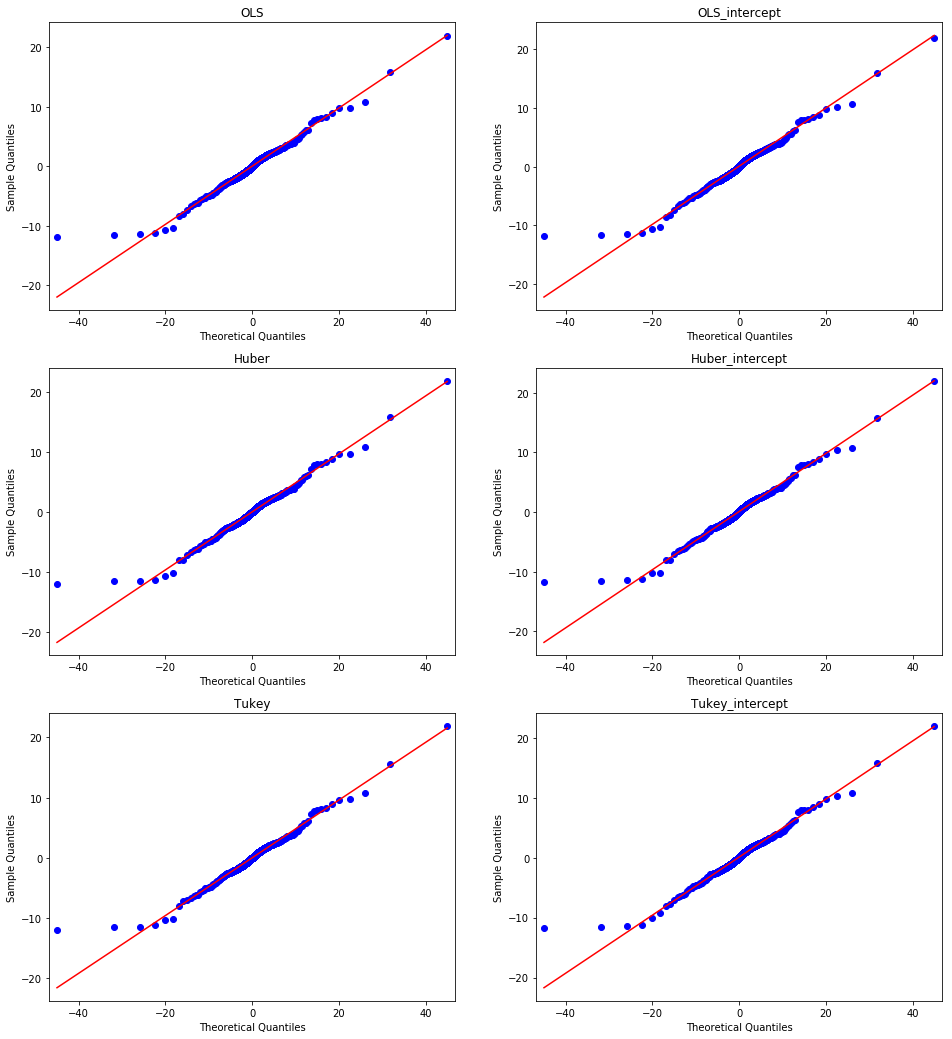

In [440]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(16, 18))
ax = ax.flatten()

for i in range(6):
    qqplot(norm_oos_resid[i].flatten(), dist=stats.t, distargs=(2,), ax=ax[i], line='r')
    ax[i].set_title(model_names[i])

#### RR Plots

Finally, we visualize our results by making residual-residual plots. From these plots we can visually compare two out of six models easily. **For dots lying on the $y = x$ line, the predictions of the two models are similarly accurate. For dots lying near $y = 0$, the model plotted on the y-axis is more accurate and for dots lying near $x = 0$, the model plotted on the x-axis is more accurate.**

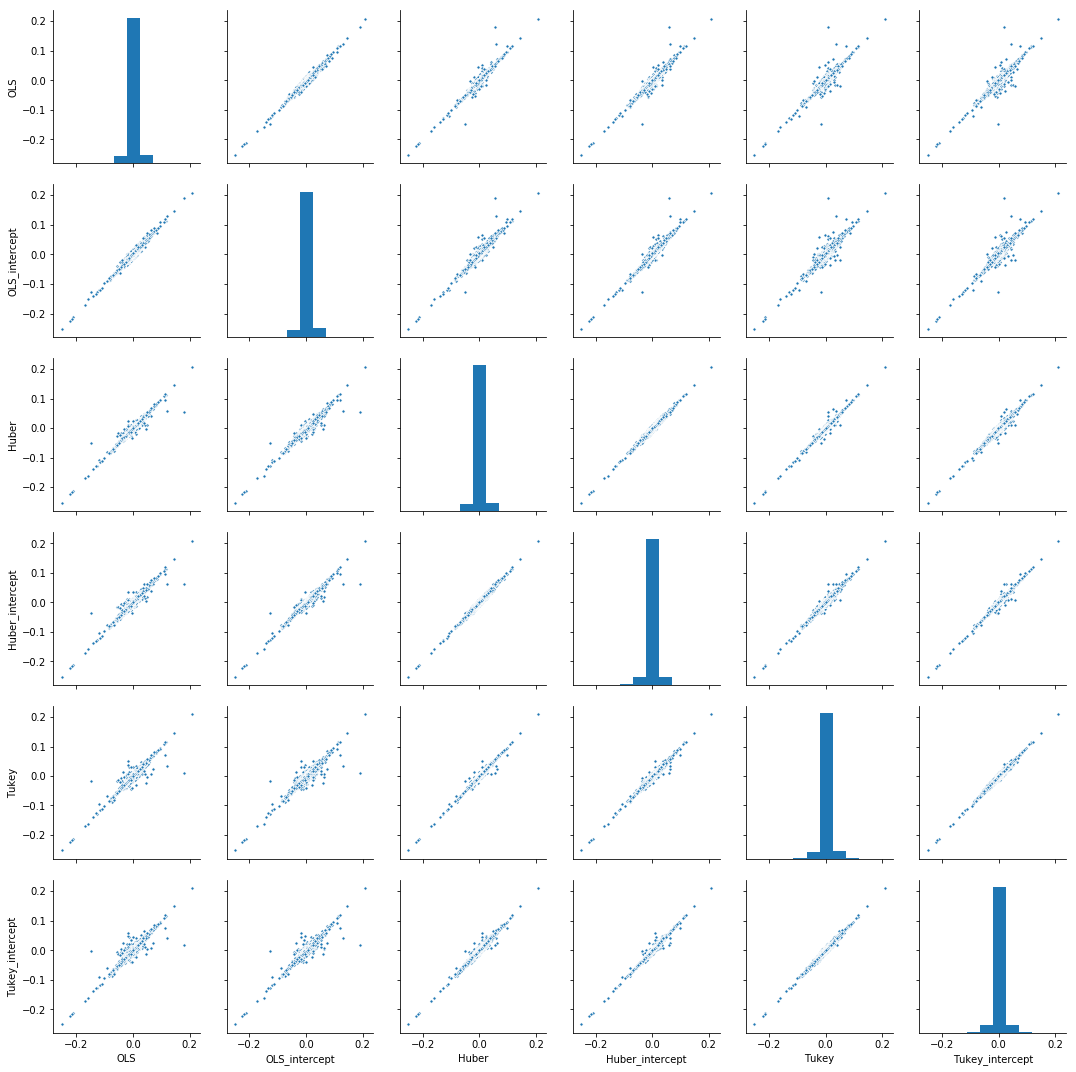

In [414]:
oos_resid_df = pd.DataFrame(np.transpose(oos_resid.reshape(6,-1)), columns=model_names)

pairplot(oos_resid_df, plot_kws={"s": 10})